In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json

import os
from dotenv import load_dotenv
load_dotenv('.env')
import google.generativeai as genai

import seaborn as sns

import torch
from transformers import pipeline

In [7]:
# Instanciando o modelo LLM
genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")

# EXERCÍCIO 3

In [8]:
url_base = "https://dadosabertos.camara.leg.br/api/v2"

In [9]:
def deputados():
    url = f"{url_base}/deputados"
    response = requests.get(url, params={'dataInicio': '2024-08-01', 'dataFim': '2024-08-30'})
    
    if response.status_code == 200:
        deputados_data = response.json()["dados"]
        df_deputados = pd.DataFrame(deputados_data)
        df_deputados.to_parquet("data/deputados.parquet", index=False)
        print("Dados dos deputados salvos em data/deputados.parquet")
    else:
        print(f"Erro ao acessar API: {response.status_code}")

### b)

In [10]:
prompt_grafico = """
A partir do arquivo deputados.parquet, contendo os dados dos deputados federais, gere um código Python que crie um gráfico
de pizza com o total e percentual de cada deputado por partido, usando as bibliotecas Pandas e Matplotlib.

Nos dados, há a informação de cada partido na coluna siglaPartido.

Por fim, salve o gráfico em um arquivo PNG no diretório "docs/distribuicao_deputados.png".

Retorne somente o código em Python, sem nenhum texto adicional.
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_grafico)
print(response.text)

```python
import pandas as pd
import matplotlib.pyplot as plt

# Carrega os dados do arquivo parquet
df = pd.read_parquet('deputados.parquet')

# Conta a quantidade de deputados por partido
partidos = df['siglaPartido'].value_counts()

# Cria o gráfico de pizza
plt.figure(figsize=(10, 10))
plt.pie(partidos, labels=partidos.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição de Deputados por Partido')
plt.axis('equal')  # Garante que o gráfico seja um círculo

# Salva o gráfico em um arquivo PNG
plt.savefig('docs/distribuicao_deputados.png')

```



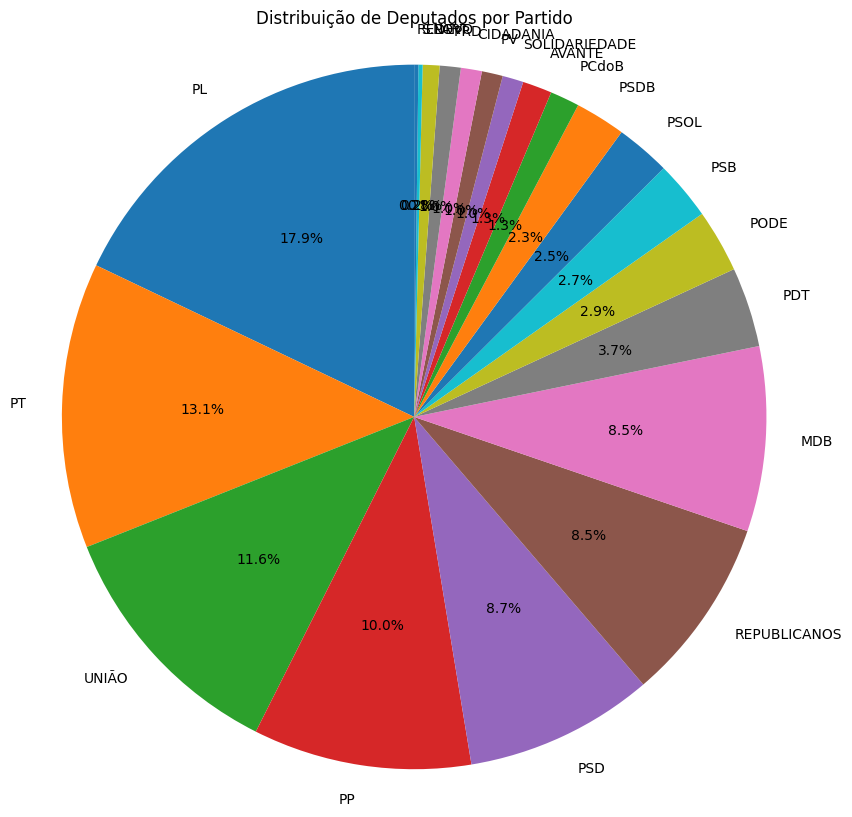

In [11]:
# Lê o arquivo parquet
df = pd.read_parquet("./data/deputados.parquet") #ajustei o caminho correto

# Conta a ocorrência de cada partido
partidos = df['siglaPartido'].value_counts()

# Cria o gráfico de pizza
plt.figure(figsize=(10, 10))
plt.pie(partidos, labels=partidos.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Deputados por Partido')
plt.axis('equal')  # Garante que o gráfico seja um círculo

# Salva o gráfico em um arquivo PNG
plt.savefig("docs/distribuicao_deputados.png")

### c)

In [12]:
df = pd.read_parquet("./data/deputados.parquet")
partidos = df['siglaPartido'].value_counts()
partidos_texto = str(partidos.to_dict())

prompt_insights = f"""
Você é um especialista em política brasileira, e cobre o cotidiano da Câmara dos Deputados.

Faça uma análise da distribuição dos deputados por partido e discorra sobre como isso pode afetar o funcionamento da
Câmara e da política brasileira em geral, em relação às dinâmicas de concentração/dispersão partidária.

Retorne a análise numa estrutura JSON (insight1, insight2, insight3)
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_insights)
print(response.text)

```json
{
  "insights": [
    {
      "insightId": 1,
      "title": "Concentração de Poder em Poucos Partidos: Uma Tendência Preocupante",
      "description": "A Câmara dos Deputados brasileira frequentemente demonstra uma concentração significativa de poder em poucos partidos.  Embora o número de partidos seja elevado,  uma pequena parcela deles detém a maioria dos assentos.  Essa dinâmica, observada nas últimas legislaturas, gera consequências negativas.  Primeiro, dificulta a formação de coalizões amplas e representativas, levando à governança por acordos negociados entre poucos atores, muitas vezes em detrimento do debate plural e da consideração de diferentes perspectivas.  Segundo, favorece a prática do clientelismo e o fisiologismo, com a negociação de cargos e verbas para garantir apoio parlamentar, em vez de um foco em projetos de interesse público. Terceiro,  limita a capacidade de renovação política e a emergência de novas lideranças, consolidando o poder de grupos estabel

In [13]:
clean_response= response.text.replace("```json\n",'').replace("\n```",'')
insights = json.loads(clean_response)

with open("./data/insights_distribuicao_deputados.json", "w") as file:
    json.dump(insights, file, indent=4, ensure_ascii=False)

Ao definir o prompt, algumas técnicas foram seguidas para um resultado mais refinado:
- Dados: foi especificado exatamente a base de dados que o LLM deveria analisar, incluindo a coluna de referência;
- Persona: o LLM foi designado como um especialista em política BR, como uma espécie de repórter que cobre in loco os trabalhos da Câmara dos Deputados;
- Exemplos: houve um direcionamento para a resposta, que é a questão da influência da concentração partidária para o funcionamento da própria Câmara e da política BR em geral.

Os insights retornados foram dentro do esperado, mencionando a concentração de poder, formação de coligações como blocos partidários, ainda que haja uma fragmentação ideológica dentro dos próprios partidos, o que acaba por gerar certa instabilidade e atrasar o encaminhamento de temas de relevância nacional, que perpassam o espectro ideológico. Os exemplos citados também foram bons, em consonância com o descrito em cada insight.

# EXERCÍCIO 4

### a)

In [14]:
def despesas_dep():
    url = f'{url_base}/deputados'
    response = requests.get(url, params={'dataInicio': '2024-08-01', 'dataFim': '2024-08-30'})
    deputados = pd.DataFrame().from_dict(response.json()['dados'])
    lista_despesas = []

    for _, deputado in deputados.iterrows():
        id = deputado['id']
        nome = deputado['nome']
        despesas = requests.get(f'{url}/{id}/despesas').json()['dados']

        for despesa in despesas:

            tipo_despesa = despesa.get("tipoDespesa", "Não informado")
            valor_documento = despesa.get("valorDocumento", 0.0)
            data_documento = despesa.get("dataDocumento", "Não informado")

            lista_despesas.append({
                "id": id,
                "nome": nome,
                "tipo_despesa": tipo_despesa,
                "valor_documento": valor_documento,
                "data_documento": data_documento
            })

    df_despesas = pd.DataFrame(lista_despesas)
    df_despesas.to_parquet('./data/serie_despesas_diárias_deputados.parquet', index=False)
    print('Despesas incluídas com sucesso')
    return df_despesas

if __name__ == "__main__":
    despesas_dep()

Despesas incluídas com sucesso


### b)

In [15]:
df_despesas = pd.read_parquet("./data/serie_despesas_diárias_deputados.parquet").sample(10)

prompt_despesas = f"""
Agora, além de especialista em política BR, você também domina a arte de Data Science. No arquivo 
serie_despesas_diárias_deputados.parquet, há colunas para id, nome, tipo_despesa, valor_documento e data_documento.

Gere um código Python que faça 3 análises simples dos dados destas despesas.
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_despesas)
print(response.text)

```python
import pandas as pd
import plotly.express as px

# Carrega o arquivo parquet
try:
    df = pd.read_parquet("serie_despesas_diárias_deputados.parquet")
except FileNotFoundError:
    print("Erro: Arquivo 'serie_despesas_diárias_deputados.parquet' não encontrado. Certifique-se de que ele esteja no mesmo diretório do script.")
    exit()


# Limpeza de dados (opcional, mas recomendado) -  Lidando com valores ausentes e inconsistências
df.dropna(subset=['valor_documento'], inplace=True) #remove linhas com valor_documento faltando
df['valor_documento'] = pd.to_numeric(df['valor_documento'], errors='coerce') #converte para numérico, tratando erros de conversão
df.dropna(subset=['valor_documento'], inplace=True) #remove linhas com valor_documento após conversão

df['data_documento'] = pd.to_datetime(df['data_documento'], errors='coerce') #converte para datetime, tratando erros
df.dropna(subset=['data_documento'], inplace=True)


# Análise 1: Top 10 Deputados com maiores despesas tota


Análise 1: Despesas totais por tipo de despesa:
 tipo_despesa
COMBUSTÍVEIS E LUBRIFICANTES.                                1362773.84
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.                         3731769.93
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR                       730.13
HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.         24223.82
LOCAÇÃO OU FRETAMENTO DE AERONAVES                             77000.00
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES                           48000.00
LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES                 442200.81
MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR    8409282.75
PASSAGEM AÉREA - REEMBOLSO                                     38474.74
PASSAGEM AÉREA - SIGEPA                                        24169.87
SERVIÇO DE SEGURANÇA PRESTADO POR EMPRESA ESPECIALIZADA.        2100.00
SERVIÇO DE TÁXI, PEDÁGIO E ESTACIONAMENTO                       1177.61
TELEFONIA                                                      18536.04
N

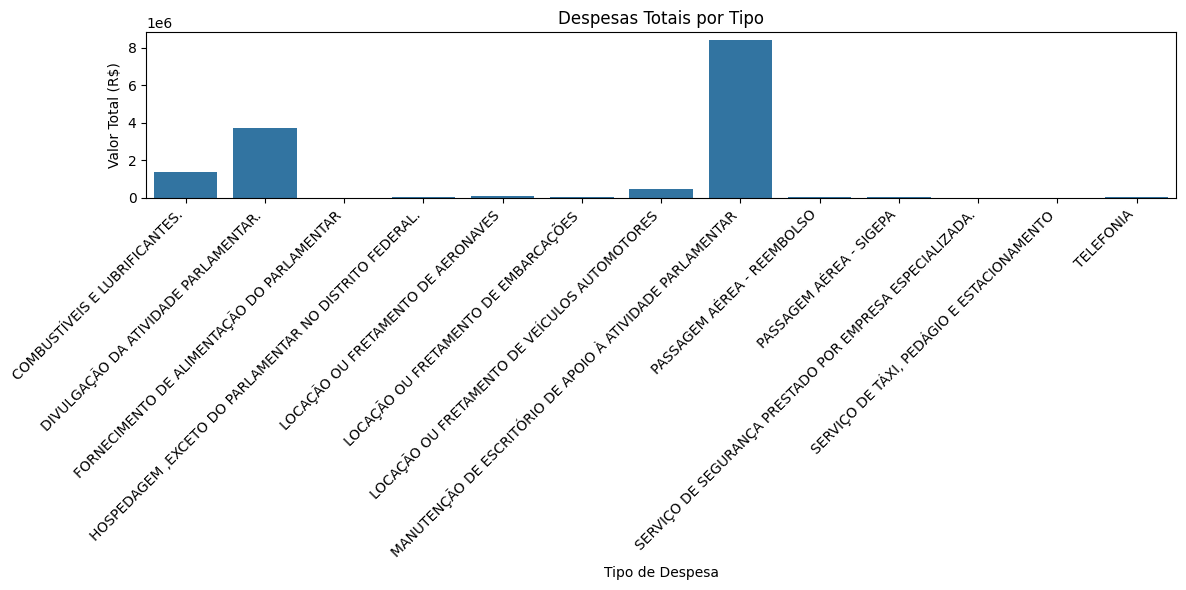

In [16]:
# Análise 1: Despesas totais por tipo de despesa

# Carrega os dados
try:
    df = pd.read_parquet("./data/serie_despesas_diárias_deputados.parquet")
except FileNotFoundError:
    print("Erro: Arquivo 'serie_despesas_diárias_deputados.parquet' não encontrado.")
    exit()

despesas_por_tipo = df.groupby('tipo_despesa')['valor_documento'].sum()
print("\nAnálise 1: Despesas totais por tipo de despesa:\n", despesas_por_tipo)

plt.figure(figsize=(12, 6))
sns.barplot(x=despesas_por_tipo.index, y=despesas_por_tipo.values)
plt.xticks(rotation=45, ha='right')
plt.title('Despesas Totais por Tipo')
plt.xlabel('Tipo de Despesa')
plt.ylabel('Valor Total (R$)')
plt.tight_layout()
plt.show()


Análise 2: 10 Deputados com maiores despesas:
 nome
Giacobo                260491.96
Olival Marques         260133.35
Glaustin da Fokus      254286.20
Eunício Oliveira       239122.30
Gabriel Mota           235500.00
Silas Câmara           212955.52
Damião Feliciano       209589.36
Antônia Lúcia          198504.60
Pr. Marco Feliciano    196023.43
Sonize Barbosa         192182.20
Name: valor_documento, dtype: float64


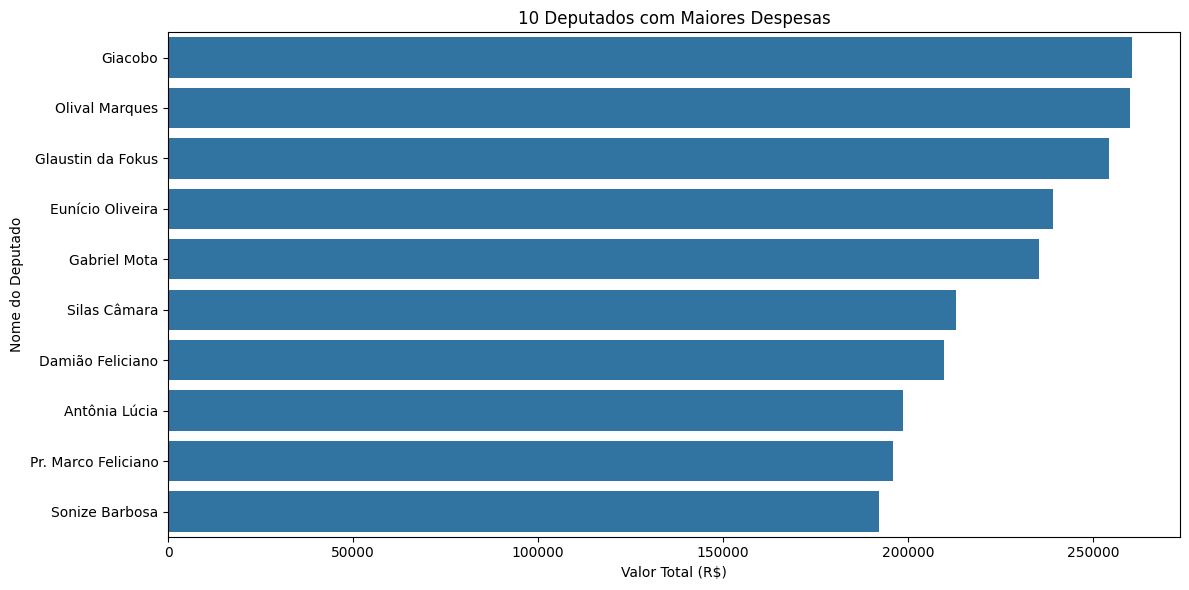

In [17]:
# Análise 2: 10 Deputados com maiores despesas

top_10_deputados = df.groupby('nome')['valor_documento'].sum().nlargest(10)
print("\nAnálise 2: 10 Deputados com maiores despesas:\n", top_10_deputados)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_deputados.values, y=top_10_deputados.index)
plt.title('10 Deputados com Maiores Despesas')
plt.xlabel('Valor Total (R$)')
plt.ylabel('Nome do Deputado')
plt.tight_layout()
plt.show()


Análise 3: Despesas ao longo do tempo (mensais):
 data_documento
2024-06    1329480.81
2024-07    2845606.26
2024-08    2641580.52
2024-09    2428654.24
2024-10    2488177.22
2024-11    1938727.33
2024-12     508213.16
Freq: M, Name: valor_documento, dtype: float64


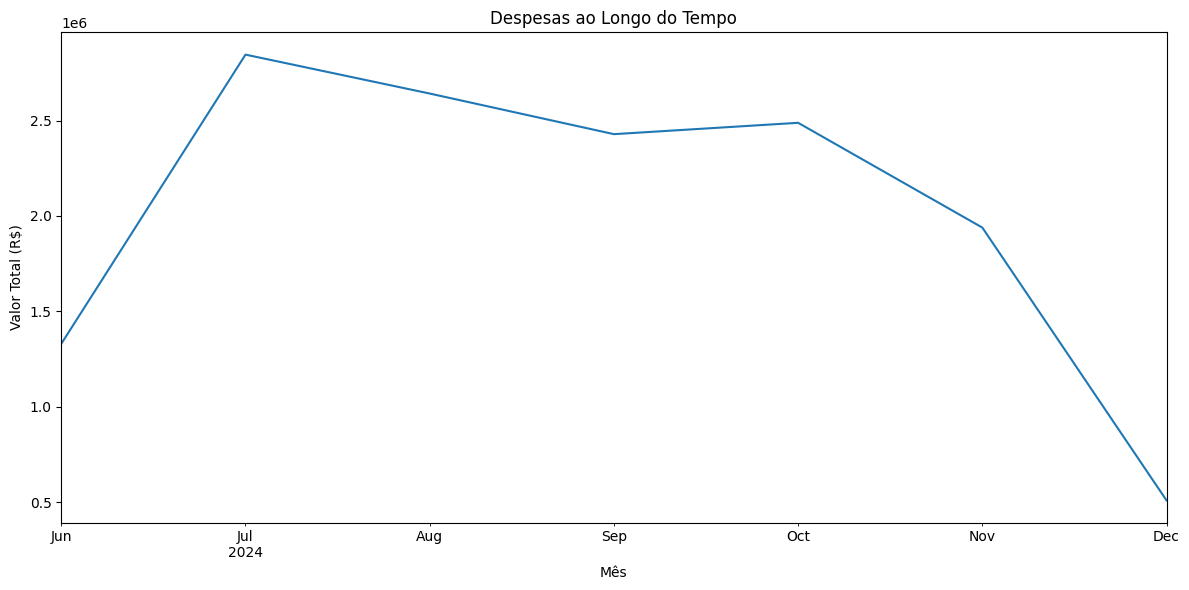

In [18]:
# Análise 3: Despesas ao longo do tempo (simplificado - precisa de data mais precisa)
#  Esta análise assume que a coluna 'data_documento' está num formato que o pandas reconhece como data.
# Se não estiver, você precisará converter para um formato de data válido (ex: pd.to_datetime)

try:
    df['data_documento'] = pd.to_datetime(df['data_documento'])
    despesas_ao_longo_do_tempo = df.groupby(df['data_documento'].dt.to_period('M'))['valor_documento'].sum()
    print("\nAnálise 3: Despesas ao longo do tempo (mensais):\n", despesas_ao_longo_do_tempo)

    plt.figure(figsize=(12, 6))
    despesas_ao_longo_do_tempo.plot()
    plt.title('Despesas ao Longo do Tempo')
    plt.xlabel('Mês')
    plt.ylabel('Valor Total (R$)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"\nErro na Análise 3: Não foi possível processar a coluna 'data_documento'. Detalhe: {e}")

### c)

In [19]:
prompt_analise = f"""
Com base na análise feita nas células anteriores, em relação ao arquivo serie_despesas_diárias_deputados.parquet
gere insights textuais (sem necessidade de apresentar informações sobre tipo de dados e labels) sobre cada uma das 
tabelas e gráficos com os dados da Câmara de Deputados.

- Despesas totais por tipo de despesa:
{despesas_por_tipo}

- 10 Deputados com maiores despesas:
{top_10_deputados}

- Despesas ao longo do tempo:
{despesas_ao_longo_do_tempo}

Retorne a análise numa estrutura JSON (insight1, insight2, insight3)
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(prompt_analise)
print(response.text)

```json
{
  "insights": [
    {
      "insight1": "A maior parte das despesas da Câmara dos Deputados se concentra na manutenção de escritórios de apoio à atividade parlamentar, seguida pela divulgação da atividade parlamentar.  Outras despesas, como combustíveis, locação de veículos e passagens aéreas, representam valores significativamente menores em comparação."
    },
    {
      "insight2": "Os deputados Giacobo e Olival Marques lideram o ranking de maiores despesas individuais, com valores próximos a R$ 260.000,00.  A diferença entre os dez deputados com maiores despesas e os demais é significativa, indicando uma concentração considerável de gastos em um pequeno grupo."
    },
    {
      "insight3": "As despesas da Câmara dos Deputados apresentaram um pico em julho de 2024, seguido por uma tendência de queda ao longo dos meses subsequentes, com uma queda acentuada em dezembro de 2024.  Observa-se uma variação considerável nas despesas mensais."
    }
  ]
}
```



In [20]:
clean_response= response.text.replace("```json\n",'').replace("\n```",'')
insights = json.loads(clean_response)


with open("./data/insights_despesas_deputados.json", "w") as file:
    json.dump(insights, file, indent=4, ensure_ascii=False)

# EXERCÍCIO 5

### a)

In [21]:
def proposicoes(dataInicio, dataFim):
    temas = {40: "Economia", 46: "Educação", 62: "Ciência, Tecnologia e Inovação"}
    proposicoes_lista = []

    for codigo, tema in temas.items():
        url = f'{url_base}/proposicoes'
        params = {
            'dataInicio': dataInicio,
            'dataFim': dataFim,
            'codTema': codigo,
            'itens': 10
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            proposicoes_data = response.json()['dados']
            for proposicao in proposicoes_data:
                proposicao['tema'] = tema
                proposicoes_lista.append(proposicao)
        else:
            print(f'Erro ao acessar proposições do tema {tema}: {response.status_code}')

    df_proposicoes = pd.DataFrame(proposicoes_lista)
    df_proposicoes.to_parquet('./data/proposicoes_deputados.parquet', index=False)
    print('Dados das proposições salvos em data/proposicoes_deputados.parquet')

if __name__ == "__main__":
    proposicoes("2024-01-01", "2024-12-31")

Dados das proposições salvos em data/proposicoes_deputados.parquet


### b)

In [22]:
df_prop = pd.read_parquet('./data/proposicoes_deputados.parquet')

lista_ementas = df_prop['ementa'].tolist()

tamanho_janela = 15
sobreposicao_janelas = 3
grupos_ementas = []

for inicio in range(0, len(lista_ementas), tamanho_janela - sobreposicao_janelas):
    grupo = lista_ementas[inicio:inicio + tamanho_janela]
    grupos_ementas.append(grupo)

In [23]:
resumos_grupos = []

for indice, grupo in enumerate(grupos_ementas):
    prompt_chunks = f"""
    Você é um especialista em política BR cobrindo as atividades da câmara dos deputados.
    Faça um resumo das ementas abaixo:
    {grupo}
    """

    genai.configure(api_key=os.environ["GEMINI_API_KEY"])
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt_chunks)
    resposta_resumo = response.text
    
    print(f'=== Resumo do Grupo {indice + 1} ===')
    print(resposta_resumo)
    
    resumos_grupos.append(resposta_resumo)

=== Resumo do Grupo 1 ===
A Câmara dos Deputados está analisando uma série de projetos de lei com temas diversos.  Podemos agrupá-los em algumas categorias:

**1.  Ajustes ao Decreto-Lei nº 73/66 (Sistema Nacional de Seguros Privados):**  Vários projetos (pelo menos quatro) buscam alterar esse decreto, principalmente para estabelecer prazos máximos para pagamento de indenizações por sinistros e definir multas por descumprimento. Um deles também propõe a inclusão de um novo artigo e a renumeração dos artigos existentes.

**2.  Gestão Fiscal e Dívida Pública:**  Um projeto estabelece limites para a dívida pública mobiliária federal. Outro exclui recursos da vinculação constitucional ao ensino do limite de gasto com pessoal, conforme a Lei de Responsabilidade Fiscal (LRF).

**3.  Privatizações e Controle Acionário:** Um projeto proíbe a alienação, pela União, do controle acionário de empresas específicas.

**4.  Criação de Distritos Agropecuários:** Dois projetos autorizam a criação de di

In [24]:
proposicoes_json = {
    'sumarizacao_proposicoes': resumos_grupos
}

caminho_arquivo = './data/sumarizacao_proposicoes.json'
with open(caminho_arquivo, 'w', encoding='utf-8') as arquivo:
    json.dump(proposicoes_json, arquivo, ensure_ascii=False, indent=4)

print(f"Arquivo JSON salvo em: {caminho_arquivo}")

Arquivo JSON salvo em: ./data/sumarizacao_proposicoes.json


Os resumos dão uma ideia dos temas propostos pela Câmara, mas como se tratam de resumos, carecem de um contexto para maior entendimento. É possível ter uma ideia geral de cada tópico, mas, como bem definiu um dos chunks:

"Em resumo, a pauta da Câmara demonstra uma variedade de interesses, desde a regulação de setores econômicos importantes até questões sociais como educação e acessibilidade.  A análise detalhada de cada projeto é necessária para compreender o impacto específico de cada um."

# EXERCÍCIO 6

In [25]:
# Criando a aplicação
CoT1 = """
Crie o esqueleto de uma aplicação Streamlit com três abas: Overview, Despesas e Proposições:
- Overview: Descreve o projeto e exibe informações básicas sobre o funcionamento e composição da Câmara dos Deputados;
- Despesas: Exibe os principais insights sobre as despesas de cada deputado;
- Proposições: Resume ementas de 10 proposições sobre os temas de Economia, Educação e Ciência.

Exiba apenas o código Python, sem nenhuma explicação textual.
"""

response1 = model.generate_content(CoT1)
print(response1.text)

```python
import streamlit as st

st.set_page_config(page_title="Câmara dos Deputados", layout="wide")

page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])

if page == "Overview":
    st.title("Overview: Câmara dos Deputados")
    st.write("Descrição do projeto e informações básicas sobre a Câmara dos Deputados.")
    st.write("Funcionamento e composição da Câmara.")

elif page == "Despesas":
    st.title("Despesas dos Deputados")
    st.write("Insights sobre as despesas de cada deputado.")
    # Adicionar visualizações de dados aqui (ex: gráficos, tabelas)


elif page == "Proposições":
    st.title("Proposições")
    st.write("Resumo das ementas de 10 proposições sobre Economia, Educação e Ciência.")
    # Adicionar visualizações de dados aqui (ex: tabelas com ementas resumidas)

```



In [26]:
%%writefile dashboard.py

import streamlit as st

st.set_page_config(page_title="Câmara dos Deputados", layout="wide")

page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])

if page == "Overview":
    st.title("Overview da Câmara dos Deputados")
    st.write("Descrição do projeto e informações básicas sobre a Câmara.")
    # Adicione informações sobre a Câmara dos Deputados aqui

elif page == "Despesas":
    st.title("Despesas dos Deputados")
    # Adicione visualizações de dados sobre despesas dos deputados aqui

elif page == "Proposições":
    st.title("Proposições")
    # Adicione um resumo das ementas de 10 proposições aqui, separadas por tema (Economia, Educação, Ciência)

Overwriting dashboard.py


In [33]:
CoT2 = f"""
Tomando como base o código inicial {response1} gerado para a aplicação Streamlit com os dados da Câmara dos Deputados, escreva
um código em Python (sem explicações textuais) para a aba Overview, baseado no arquivo config.yaml (./data/config.yaml).
O texto deve ser obtido a partir da chave overview_summary, exibindo-o na aba Overview. A estrutura do arquivo é data: config: overview_summary
Certifique-se de que o texto esteja livre de problemas de encoding, como caracteres mal-formados resultantes de conversão 
de UTF-8/ISO-8859-1. Substitua sequências como 'CÃ¢mara' por 'Câmara' e corrija automaticamente outras palavras semelhantes.

Lembre-se de manter a mesma estrutura de código já escrita até aqui.

Forneça também um título para o projeto, que deve ser "Dashboard - Câmara dos Deputados (ago/2024)".
"""

response2 = model.generate_content(CoT2)
print(response2.text)

```python
import streamlit as st
import yaml

with open("./data/config.yaml", 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)

st.set_page_config(page_title="Dashboard - Câmara dos Deputados (ago/2024)", layout="wide")

page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])

if page == "Overview":
    st.title("Overview: Câmara dos Deputados")
    overview_text = config['data']['config']['overview_summary']
    st.write(overview_text)

elif page == "Despesas":
    st.title("Despesas dos Deputados")
    st.write("Insights sobre as despesas de cada deputado.")

elif page == "Proposições":
    st.title("Proposições")
    st.write("Resumo das ementas de 10 proposições sobre Economia, Educação e Ciência.")

```

Para que este código funcione, você precisa criar um arquivo `config.yaml` na pasta `./data/` com o seguinte conteúdo:

```yaml
data:
  config:
    overview_summary: "Este é um texto de exemplo para a aba Overview.  Ele descreve o projeto e i

In [28]:
CoT3 = f"""
Tomando como base os dois códigos gerados até aqui em {response1, response2}, e mantendo a mesma estrutura, forneça um código
Python que leia o arquivo da pasta ./docs/distribuicao_deputados.png e o exiba na aba Overview. A imagem deve conter um título
no dashboard (e não apenas na legenda da imagem) que dê destaque para o gráfico, separando-o e o mantendo abaixo do resumo
sumarizado já disponível em {response2}.
"""

response3 = model.generate_content(CoT3)
print(response3.text)

```python
import streamlit as st
import yaml
from PIL import Image

with open('./data/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

st.set_page_config(page_title="Dashboard - Câmara dos Deputados (ago/2024)", layout="wide")

page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])

if page == "Overview":
    st.title("Overview: Câmara dos Deputados")
    st.write(config['data']['config']['overview_summary'])

    try:
        st.markdown("""---""") # Adiciona uma linha separadora
        st.subheader("Distribuição dos Deputados") # Título para o gráfico
        image = Image.open('./docs/distribuicao_deputados.png')
        st.image(image, use_column_width=True)
    except FileNotFoundError:
        st.error("Imagem não encontrada. Certifique-se de que o arquivo 'distribuicao_deputados.png' esteja na pasta './docs/'")


elif page == "Despesas":
    st.title("Despesas dos Deputados")
    st.write("Insights sobre as despesas de cada deputado.")

elif

In [32]:
CoT4 = f"""
Tomando como base os três códigos gerados até aqui em {response1, response2, response3}, e mantendo a mesma estrutura, 
forneça um código Python que leia o arquivo da pasta ('./data/insights_distribuicao_deputados.json) e o exiba também na
aba Overview, com um separador abaixo do gráfico com a distribuição dos deputados.

Lembre-se que o arquivo JSON possui a seguinte estrutura:

'insights': [{'insight1'}, {'insight2'}, {'insight3'}]
"""

response4 = model.generate_content(CoT4)
print(response4.text)

```python
import streamlit as st
import yaml
from PIL import Image
import json

with open('./data/config.yaml', 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)

st.set_page_config(page_title="Dashboard - Câmara dos Deputados (ago/2024)", layout="wide")

page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])

if page == "Overview":
    st.title("Overview: Câmara dos Deputados")
    st.write(config['data']['config']['overview_summary'])

    try:
        st.markdown("""---""")
        st.subheader("Distribuição dos Deputados")
        image = Image.open('./docs/distribuicao_deputados.png')
        st.image(image, use_column_width=True)
    except FileNotFoundError:
        st.error("Imagem não encontrada. Certifique-se de que o arquivo 'distribuicao_deputados.png' esteja na pasta './docs/'")
    except Exception as e:
        st.error(f"Erro ao carregar a imagem: {e}")


    try:
        st.markdown("""---""")
        st.subheader("Insights sobre 

# EXERCÍCIO 7

In [31]:
batch_prompt1 = f"""
Tomando como base os códigos gerados até aqui em {response1, response2, response3, response4}, e mantendo a mesma estrutura, 
forneça um código Python para preenchimento das abas 'Despesas' e 'Proposições'. Certifique-se de que o texto esteja livre
de problemas de encoding, como caracteres mal-formados resultantes de conversão de UTF-8/ISO-8859-1. 
Substitua sequências como 'CÃ¢mara' por 'Câmara' e corrija automaticamente outras palavras semelhantes.

1. Na aba Despesas, você deverá ler o arquivo {insights} da pasta (.\AT\data\insights_despesas_deputados.json).
2. Após, leia o arquivo {df_despesas}, da pasta (.\AT\data\serie_despesas_diárias_deputados.parquet) e crie um st.selectbox 
para seleção de cada deputado.
3. Exiba um gráfico de barras com a série temporal de despesas do deputado selecionado.

4. Já na aba Proposições, mostre a tabela com os dados contido em {proposicoes}, da pasta (.\AT\data\proposicoes_deputados.parquet)
5. Em seguida, faça um resumo das proposições {proposicoes_json}, da pasta (.\AT\data\sumarizacao_proposicoes.json).
"""

response_batch = model.generate_content(batch_prompt1)
print(response_batch.text)

```python
import streamlit as st
import yaml
from PIL import Image
import json
import pandas as pd
import plotly.express as px

# Configurações do Streamlit
st.set_page_config(page_title="Dashboard - Câmara dos Deputados (ago/2024)", layout="wide")

# Carregar o arquivo de configuração YAML
with open('./data/config.yaml', 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)

# Menu de navegação lateral
page = st.sidebar.radio("Navegação", ["Overview", "Despesas", "Proposições"])


if page == "Overview":
    st.title("Overview: Câmara dos Deputados")
    st.write(config['data']['config']['overview_summary'])

    try:
        st.markdown("---")
        st.subheader("Distribuição dos Deputados")
        image = Image.open('./docs/distribuicao_deputados.png')
        st.image(image, use_column_width=True)
    except FileNotFoundError:
        st.error("Imagem não encontrada. Certifique-se de que o arquivo 'distribuicao_deputados.png' esteja na pasta './docs/'")

    try:
    

### f)

Ambas as técnicas são bem úteis para desenvolvimento de um projeto Streamlit, ainda que haja alguns erros que precisem ser corrigidos ao longo do processo.

Por mais que a técnica chain-of-thoughts seja mais fácil de corrigir eventuais erros de geração de código do LLM, particularmente precisei testar os prompts mais vezes em comparação com a técnica batch prompting, mas pode ter sido mera obra do acaso mesmo, visto que é mais fácil trabalhar com iterações fracionadas do que um único prompt que passe todas as instruções necessárias.

# EXERCÍCIO 8

### a)

A técnica self-ask consiste em fragmentar uma instrução ou pergunta complexa em partes menores, reunindo as informações gradualmente a partir dessas etapas simplificadas.

Por exemplo, ao responder à pergunta "Qual é o partido político com mais deputados na Câmara?", o modelo poderia quebrá-la em questões menores, como: Quais são os partidos presentes na Câmara? Quantos deputados cada partido possui? Por fim, qual partido possui o maior número de parlamentares?

Então, ao combinar esse processo com uma busca semântica em dados vetorizados, o modelo conseguiria focar melhor nas instruções e aprender apenas com as informações mais relevantes para responder à pergunta original.